# Analyse des retards aériens

## Structure du dataset

| Variable              | Description courte                                                                    | Type    | Exemples                     |
| --------------------- | ------------------------------------------------------------------------------------- | ------- | ---------------------------- |
| `year`                | Année de collecte des données                                                         | int     | 2023, 2024                   |
| `month`               | Mois (représenté numériquement)                                                       | int     | 1, 6, 12                     |
| `carrier`             | Code du transporteur aérien                                                           | object  | 'AA', 'DL', 'UA'             |
| `carrier_name`        | Nom complet du transporteur aérien                                                    | object  | 'American Airlines', 'Delta' |
| `airport`             | Code de l'aéroport (IATA)                                                             | object  | 'JFK', 'LAX', 'ATL'          |
| `airport_name`        | Nom complet de l'aéroport                                                             | object  | 'John F. Kennedy Intl'       |
| `arr_flights`         | Nombre de vols arrivant à l'aéroport                                                  | int     | 1500, 2300                   |
| `arr_del15`           | Nombre de vols en retard de plus de 15 minutes                                        | int     | 320, 450                     |
| `carrier_ct`          | Nombre de vols retardés à cause de la compagnie aérienne (ex : équipage indisponible) | float   | 45, 60                       |
| `weather_ct`          | Nombre de vols retardés en raison de la météo                                         | float   | 10, 25                       |
| `nas_ct`              | Nombre de vols retardés par le système national de l'aviation (ex : trafic aérien)    | float   | 100, 120                     |
| `security_ct`         | Nombre de vols annulés pour des raisons de sécurité                                   | float   | 0, 2                         |
| `late_aircraft_ct`    | Nombre de vols retardés à cause de l'arrivée tardive d'un avion précédent             | float   | 80, 95                       |
| `arr_cancelled`       | Nombre de vols annulés                                                                | int     | 15, 20                       |
| `arr_diverted`        | Nombre de vols déroutés vers un autre aéroport                                        | int     | 3, 5                         |
| `arr_delay`           | Temps total (en minutes) de retard des vols                                           | float   | 1240.5, 2130.0               |
| `carrier_delay`       | Durée totale (en minutes) de retard causé par la compagnie aérienne                   | float   | 300.0, 450.5                 |
| `weather_delay`       | Durée totale (en minutes) de retard causé par la météo                                | float   | 120.0, 80.0                  |
| `nas_delay`           | Durée totale (en minutes) de retard causé par le système de navigation aérienne       | float   | 500.0, 620.0                 |
| `security_delay`      | Durée totale (en minutes) de retard causé par un problème de sécurité                 | float   | 0.0, 5.0                     |
| `late_aircraft_delay` | Durée totale (en minutes) de retard causé par un vol précédent en retard              | float   | 320.0, 470.0                 |

## Import des dépendances et du dataset

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

# Chemin du dataset
csv_path = '../data/extracted/USA_Airline_Delay_Cause/Airline_Delay_Cause.csv'

## Vérification

In [15]:
# Chargement des donnnées
df = pd.read_csv(csv_path)

# Aperçu de la structure
print("Shape (lignes, colonnes) :", df.shape)
print("\nColonnes :", df.columns.tolist())
display(df.head(3))

Shape (lignes, colonnes) : (318017, 21)

Colonnes : ['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.0,...,0.0,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0
1,2022,5,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",91.0,16.0,7.38,0.0,...,0.0,6.09,0.0,0.0,884.0,351.0,0.0,81.0,0.0,452.0
2,2022,5,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",19.0,2.0,0.13,0.0,...,0.0,0.88,1.0,0.0,138.0,4.0,0.0,106.0,0.0,28.0


## Nettoyage des données

In [16]:
## Typages des données

# Affichage des types de données
print("Types de données :")
print(df.dtypes)

## Fusions des colonnes

# Fusion des colonnes 'year' et 'month' en une colonne 'date'
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2)

# Vérification
print("\nDate après conversion :")
print(df[['date']].head(5))

## Traitement des valeurs manquantes

print("\nNombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

# Suppression des lignes sans vols
df = df.dropna(subset=['arr_flights'])

# Remplissage de arr_del15 avec 0 si vide
df['arr_del15'] = df['arr_del15'].fillna(0)

# Vérification
print("\nValeurs manquantes après traitement :")
print(df.isnull().sum())

Types de données :
year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

Date après conversion :
      date
0  2022-05
1  2022-05
2  2022-05
3  2022-05
4  2022-05

Nombre de valeurs manquantes par colonne :
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights        

## Statistiques

In [22]:
# Aperçu des stats globales
print("\nRésumé statistique rapide :")
display(df.describe().T.round(2))


Résumé statistique rapide :


,count,mean,std,min,25%,50%,75%,max
year,317529.0,2012.45,5.68,2003.00,2007.00,2012.00,2018.00,2022.00
month,317529.0,6.50,3.46,1.00,3.00,6.00,9.00,12.00
arr_flights,317529.0,381.76,1027.15,1.00,59.00,120.00,273.00,21977.00
arr_del15,317529.0,72.85,198.87,0.00,9.00,23.00,56.00,6377.00
carrier_ct,317529.0,21.07,47.67,0.00,3.00,8.19,19.69,1792.07
weather_ct,317529.0,2.62,9.97,0.00,0.00,0.58,2.00,717.94
nas_ct,317529.0,24.01,85.11,-0.01,1.68,5.49,15.35,4091.27
security_ct,317529.0,0.18,0.84,0.00,0.00,0.00,0.00,80.56
late_aircraft_ct,317529.0,24.98,75.28,0.00,1.64,5.86,17.04,1885.47
arr_cancelled,317529.0,7.21,37.22,0.00,0.00,1.00,4.00,4951.00


### Calcul du score de risque et de résilience

Ce bloc calcule plusieurs indicateurs pour chaque ligne du dataset :

- `risk_score` : proportion de vols perturbés (retard >15 min, annulés ou déroutés) par rapport au nombre total de vols.
- `mttr` (Mean Time To Recovery) : temps moyen de retard par incident, toutes causes confondues.
- `mttr_norm` : version normalisée du MTTR pour faciliter la comparaison.
- `delay_rate` : taux de vols en retard (>15 min).
- `resilience_score` : indicateur de résilience, plus il est élevé, plus l'aéroport ou la compagnie gère efficacement les perturbations.

Ces indicateurs permettent d’identifier les aéroports ou compagnies les plus exposés aux risques de retard et ceux qui récupèrent le plus rapidement.

In [23]:
# Calcul du score de risque
df['risk_score'] = (df['arr_del15'] + df['arr_cancelled'] + df['arr_diverted']) / df['arr_flights']

# MTTR global
df['mttr'] = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum(axis=1) / \
             df[['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']].sum(axis=1)

# Normalisation du MTTR
df['mttr_norm'] = (df['mttr'] - df['mttr'].min()) / (df['mttr'].max() - df['mttr'].min())

# Taux de retard
df['delay_rate'] = df['arr_del15'] / df['arr_flights']

# Score de résilience
df['resilience_score'] = 1 - (df['mttr_norm'] + df['delay_rate'])

# Vérification
print("\nAperçu des nouvelles colonnes :")
print(df[['risk_score', 'mttr', 'mttr_norm', 'delay_rate', 'resilience_score']].head(5))


Aperçu des nouvelles colonnes :
   risk_score       mttr  mttr_norm  delay_rate  resilience_score
0    0.051471  36.428571   0.014046    0.051471          0.934483
1    0.175824  55.215490   0.026276    0.175824          0.797900
2    0.157895  68.656716   0.035026    0.105263          0.859711
3    0.159091  67.594575   0.034335    0.159091          0.806574
4    0.104972  42.526316   0.018016    0.104972          0.877012


### Vols retardé par cause


Nombre total de vols : 121 221 136.0
Nombre de vols retardés : 23 131 765.0


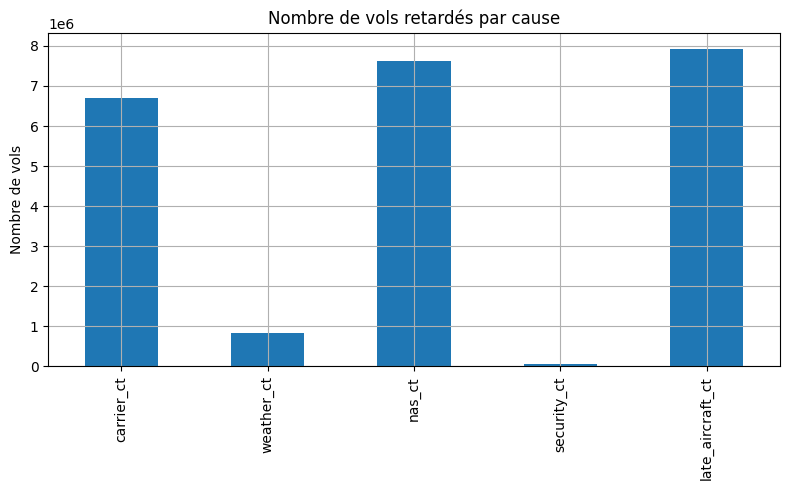

In [19]:
# Agrégation des causes de retard
causes = df[['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']].sum()

# Afficher le nombre de vols total
print("\nNombre total de vols : {:,}".format(df['arr_flights'].sum()).replace(",", " "))
print("Nombre de vols retardés : {:,}".format(df['arr_del15'].sum()).replace(",", " "))

# Graphique en barres
causes.plot(kind='bar', figsize=(8,5), title='Nombre de vols retardés par cause', ylabel='Nombre de vols')
plt.grid(True)
plt.tight_layout()

### Ratio de retard par années

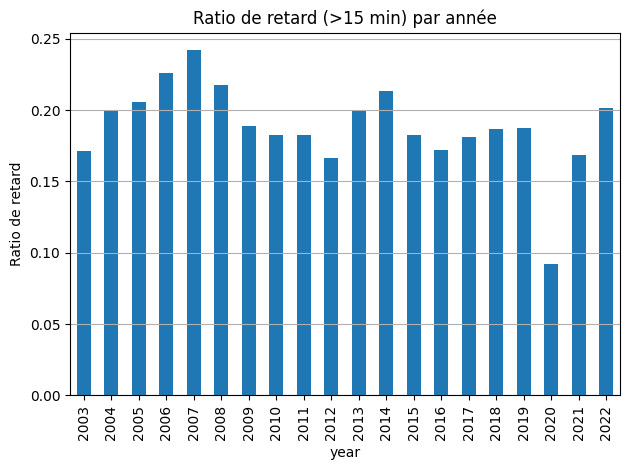

In [ ]:
# Grouper par année et calculer le ratio de retard
delay_ratio_per_year = (df.groupby('year')['arr_del15'].sum() / df.groupby('year')['arr_flights'].sum())

# Affichage
delay_ratio_per_year.plot(kind='bar', title='Ratio de retard (>15 min) par année', ylabel='Ratio de retard')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Durée totale des retards par cause

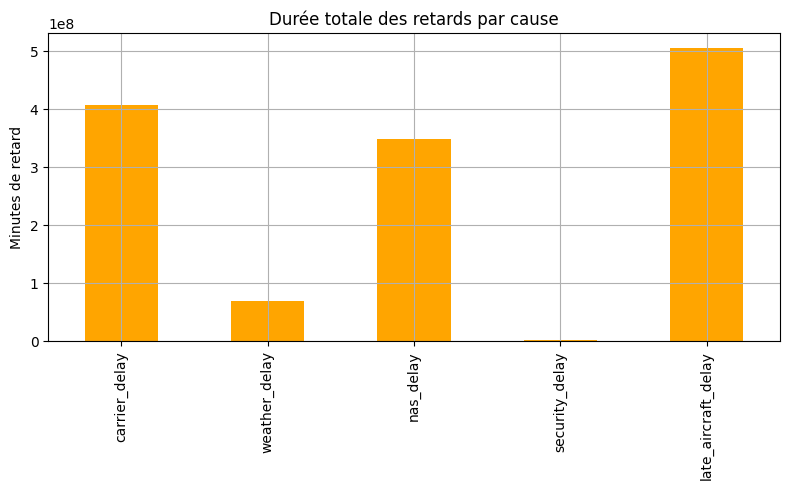

In [21]:
# Agrégation des durées de retard
delays = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum()

# Graphique
delays.plot(kind='bar', color='orange', figsize=(8,5), title='Durée totale des retards par cause', ylabel='Minutes de retard')
plt.grid(True)
plt.tight_layout()

## Export du dataset préparé pour le dashboard

In [24]:
df.to_csv("../data/cleaned/airline_delay_cause_cleaned.csv", index=False)
print("Fichier enregistré : /data/cleaned/airline_delay_cause_cleaned.csv")

Fichier enregistré : /data/cleaned/airline_delay_cause_cleaned.csv
